### Vectorización de texto y modelo de clasificación Naïve Bayes con el dataset 20 newsgroups

In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import f1_score

# 20newsgroups por ser un dataset clásico de NLP ya viene incluido y formateado
# en sklearn
from sklearn.datasets import fetch_20newsgroups
import numpy as np

import matplotlib.pyplot as plt

import textwrap

## Carga de datos

In [3]:
# cargamos los datos (ya separados de forma predeterminada en train y test)
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

## Vectorización

In [4]:
# instanciamos un vectorizador
# ver diferentes parámetros de instanciación en la documentación de sklearn
tfidfvect = TfidfVectorizer()

In [7]:
# en el atributo `data` accedemos al texto
newsgroups_train.data[90]

"Does anyone know what processor the Atari 2600 used? What I'm looking for is th\ne pin-outs for the Atari 2600.... the schematics for it it... does anyone have\nany idea where I could find this or any related information? This is very impor\ntant. Also, are the ROM chips that were used fo rthe 2600 games still available\n, or were they propreitary? Please email me with any responces, as this is very\n important.. Thanks a million...\n\nBTW- Anyone who works/has worked for Atari, I could really use your help with i\nnfo on the old 2600, please email me if you are willing to help me.... thatnks\nalot!!"

In [8]:
# con la interfaz habitual de sklearn podemos fitear el vectorizador
# (obtener el vocabulario y calcular el vector IDF)
# y transformar directamente los datos
X_train = tfidfvect.fit_transform(newsgroups_train.data)
# `X_train` la podemos denominar como la matriz documento-término

In [9]:
# recordar que las vectorizaciones por conteos son esparsas
# por ello sklearn convenientemente devuelve los vectores de documentos
# como matrices esparsas
print(type(X_train))
print(f'shape: {X_train.shape}')
print(f'cantidad de documentos: {X_train.shape[0]}')
print(f'tamaño del vocabulario (dimensionalidad de los vectores): {X_train.shape[1]}')

<class 'scipy.sparse._csr.csr_matrix'>
shape: (11314, 101631)
cantidad de documentos: 11314
tamaño del vocabulario (dimensionalidad de los vectores): 101631


In [12]:
# una vez fiteado el vectorizador, podemos acceder a atributos como el vocabulario
# aprendido. Es un diccionario que va de términos a índices.
# El índice es la posición en el vector de documento.
tfidfvect.vocabulary_['laptop']

55675

In [13]:
# es muy útil tener el diccionario opuesto que va de índices a términos
idx2word = {v: k for k,v in tfidfvect.vocabulary_.items()}

In [14]:
# en `y_train` guardamos los targets que son enteros
y_train = newsgroups_train.target
y_train[:10]

array([ 7,  4,  4,  1, 14, 16, 13,  3,  2,  4])

In [15]:
# hay 20 clases correspondientes a los 20 grupos de noticias
print(f'clases {np.unique(newsgroups_test.target)}')
newsgroups_test.target_names

clases [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

## Similaridad de documentos

In [16]:
# Veamos similaridad de documentos. Tomemos algún documento
idx = 4811
print(newsgroups_train.data[idx])

THE WHITE HOUSE

                  Office of the Press Secretary
                   (Pittsburgh, Pennslyvania)
______________________________________________________________
For Immediate Release                         April 17, 1993     

             
                  RADIO ADDRESS TO THE NATION 
                        BY THE PRESIDENT
             
                Pittsburgh International Airport
                    Pittsburgh, Pennsylvania
             
             
10:06 A.M. EDT
             
             
             THE PRESIDENT:  Good morning.  My voice is coming to
you this morning through the facilities of the oldest radio
station in America, KDKA in Pittsburgh.  I'm visiting the city to
meet personally with citizens here to discuss my plans for jobs,
health care and the economy.  But I wanted first to do my weekly
broadcast with the American people. 
             
             I'm told this station first broadcast in 1920 when
it reported that year's presidential elec

In [17]:
# midamos la similaridad coseno con todos los documentos de train
cossim = cosine_similarity(X_train[idx], X_train)[0]

In [18]:
# podemos ver los valores de similaridad ordenados de mayor a menos
np.sort(cossim)[::-1]

array([1.        , 0.70930477, 0.67474953, ..., 0.        , 0.        ,
       0.        ])

In [19]:
# y a qué documentos corresponden
np.argsort(cossim)[::-1]

array([4811, 6635, 4253, ..., 9019, 9016, 8748])

In [20]:
# los 5 documentos más similares:
mostsim = np.argsort(cossim)[::-1][1:6]

In [21]:
# el documento original pertenece a la clase:
newsgroups_train.target_names[y_train[idx]]

'talk.politics.misc'

In [22]:
# y los 5 más similares son de las clases:
for i in mostsim:
  print(newsgroups_train.target_names[y_train[i]])

talk.politics.misc
talk.politics.misc
talk.politics.misc
talk.politics.misc
talk.politics.misc


### Modelo de clasificación Naïve Bayes

In [23]:
# es muy fácil instanciar un modelo de clasificación Naïve Bayes y entrenarlo con sklearn
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB()

In [24]:
# con nuestro vectorizador ya fiteado en train, vectorizamos los textos
# del conjunto de test
X_test = tfidfvect.transform(newsgroups_test.data)
y_test = newsgroups_test.target
y_pred =  clf.predict(X_test)

In [25]:
# el F1-score es una metrica adecuada para reportar desempeño de modelos de claificación
# es robusta al desbalance de clases. El promediado 'macro' es el promedio de los
# F1-score de cada clase. El promedio 'micro' es equivalente a la accuracy que no
# es una buena métrica cuando los datasets son desbalanceados
f1_score(y_test, y_pred, average='macro')

np.float64(0.5854345727938506)

### Consigna del desafío 1

**1**. Vectorizar documentos. Tomar 5 documentos al azar y medir similaridad con el resto de los documentos.
Estudiar los 5 documentos más similares de cada uno analizar si tiene sentido
la similaridad según el contenido del texto y la etiqueta de clasificación.

**2**. Entrenar modelos de clasificación Naïve Bayes para maximizar el desempeño de clasificación
(f1-score macro) en el conjunto de datos de test. Considerar cambiar parámteros
de instanciación del vectorizador y los modelos y probar modelos de Naïve Bayes Multinomial
y ComplementNB.

**3**. Transponer la matriz documento-término. De esa manera se obtiene una matriz
término-documento que puede ser interpretada como una colección de vectorización de palabras.
Estudiar ahora similaridad entre palabras tomando 5 palabras y estudiando sus 5 más similares. **La elección de palabras no debe ser al azar para evitar la aparición de términos poco interpretables, elegirlas "manualmente"**.


In [2]:
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

tfidfvect = TfidfVectorizer()

X_train = tfidfvect.fit_transform(newsgroups_train.data)

y_train = newsgroups_train.target

idx2word = {v: k for k,v in tfidfvect.vocabulary_.items()}

#### Ejercicio 1

In [65]:
def find_most_similar(input_idx, n=5):

    cossim = cosine_similarity(X_train[input_idx], X_train)[0]

    most_similar_values = np.sort(cossim)[::-1][1:n+1]
    n_most_similar_doc = np.argsort(cossim)[::-1][1:n+1]

    sim_data = {int(sim_idx): 
                {'class' : newsgroups_train.target_names[y_train[sim_idx]],
                 'sim_value': most_similar_values[it],
                 'doc': newsgroups_train.data[sim_idx]}
                 for it, sim_idx in enumerate(n_most_similar_doc)}
    
    sim_data[input_idx] = {'class' : newsgroups_train.target_names[y_train[input_idx]],
                           'sim_value': 1,
                           'doc': newsgroups_train.data[input_idx]}
    
    return sim_data


def plot_most_similar(data):
    # Extraer las claves y los valores de 'sim_value' y 'class'
    keys = [key for key in data.keys() if data[key]['sim_value']<1]
    sim_values = [data[key]['sim_value'] for key in keys if data[key]['sim_value']<1]
    classes = [data[key]['class'] for key in keys if data[key]['sim_value']<1]

    # Crear un color para cada clase
    unique_classes = list(set(classes))
    colors = plt.cm.get_cmap('tab10', len(unique_classes))

    # Asignar un color a cada punto según su clase
    class_to_color = {cls: colors(i) for i, cls in enumerate(unique_classes)}

    # Crear el gráfico
    plt.figure(figsize=(10, 6))

    # Dibujar los puntos
    for i, key in enumerate(keys):
        plt.scatter(i, sim_values[i], color=class_to_color[classes[i]], label=classes[i])

    # Crear una leyenda única
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), title="Classes", loc='best')

    # Añadir etiquetas y título
    plt.xlabel('ID')
    plt.ylabel('Similarity Value')
    plt.title('Similarity Values by ID and Class')

    # Mostrar el gráfico
    plt.grid(True)
    plt.show()


def display_first_n_words(data, n = 30):
    for key, value in data.items():
        doc = value['doc']
        first_n_words = ' '.join(doc.split()[:n+1])
        formatted_text = textwrap.fill(first_n_words, width=70)

        if data[key]['sim_value']==1:
            print('### ORIGINAL ###')
        print(f"Document ID: {key}\nClass: {value['class']}\nSimilarity Value: {value['sim_value']:.2f}\nText Preview:\n{formatted_text}\n{'-'*80}")



In [62]:
# Creamos una lista de 5 documentos al azar:
np.random.seed(42)
indices = np.random.choice(X_train.shape[0], 5, replace=False).tolist()

indices

[7492, 3546, 5582, 4793, 3813]

/tmp/ipykernel_9602/1039797579.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_classes))


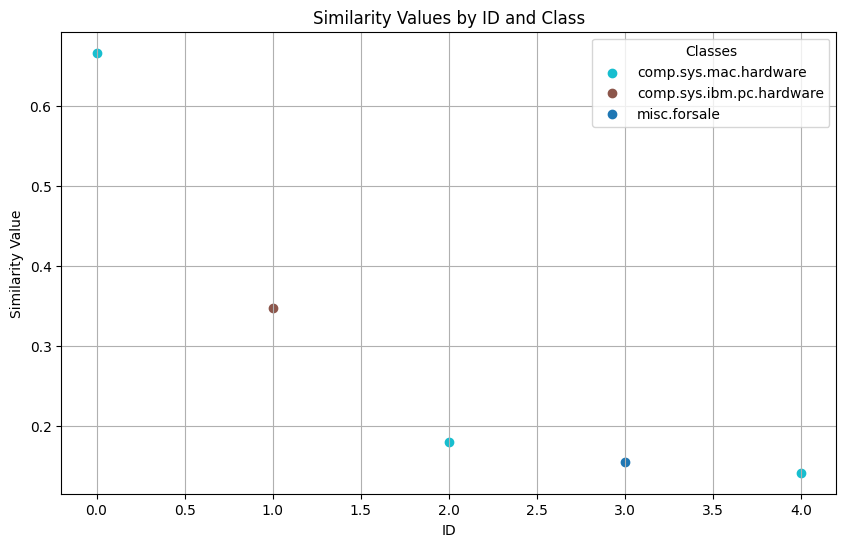

Document ID: 10935
Class: comp.sys.mac.hardware
Similarity Value: 0.67
Text Preview:
Hey everybody: I want to buy a mac and I want to get a good
price...who doesn't? So, could anyone out there who has found a really
good deal on a Centris 650 send me the price. I don't want to know
where, unless it is mail order or areound cleveland,
--------------------------------------------------------------------------------
Document ID: 7258
Class: comp.sys.ibm.pc.hardware
Similarity Value: 0.35
Text Preview:
Hay all: Has anyone out there heard of any performance stats on the
fabled p24t. I was wondering what it's performance compared to the
486/66 and/or pentium would be. Any info would be helpful. Later BoB
-- Robert Novitskey | rrn@po.cwru.edu | (216)754-2134 | CWRU Cleve.
Ohio
----------------------------------------------------------------------
COMPUTER ENGINEER AND
--------------------------------------------------------------------------------
Document ID: 4971
Class: comp.sys.mac.hardwar

In [69]:
''' 
Documento 1 (7492): 
- Clase original: comp.sys.mac.hardware
- Los mas similares pertenecen a las clases: comp.sys.mac.hardware, comp.sys.ibm.pc.hardware y misc.forsale
- Se observa que todos los textos hablan de algun tipo de hardware
'''

data = find_most_similar(indices[0])

plot_most_similar(data = data)

display_first_n_words(data = data, n = 50)

/tmp/ipykernel_9602/1039797579.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_classes))


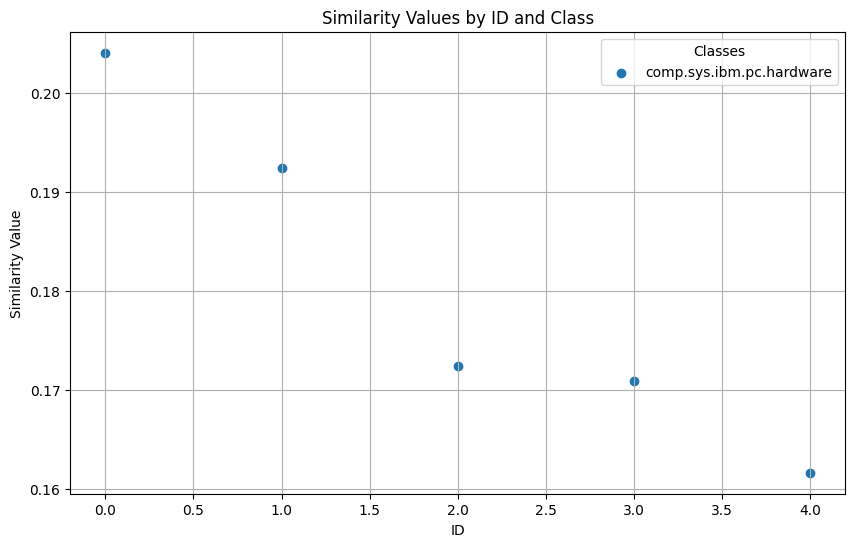

Document ID: 5665
Class: comp.sys.ibm.pc.hardware
Similarity Value: 0.20
Text Preview:
By initiating a DMA xfer. :) Seriously, busmastering adapter have
their own DMA ability, they don't use the motherboards on-board
DMA(which is *MUCH* slower). ISA has no bus arbitration, so if two
busmastering cards in 1 ISA system try to do DMA xfers on the same DMA
channel the system will lock or crash.(I forget) Their are 8 DMA
channels in an ISA system. 0-7. 0-3 are 8-bit & 4-7 are 16-bit. The
system uses DMA 0, a SoundBlaster uses DMA 1. I could buy a
busmastering XGA-2 video card & a busmastering SCSI HA. In order for
them to work
--------------------------------------------------------------------------------
Document ID: 2011
Class: comp.sys.ibm.pc.hardware
Similarity Value: 0.19
Text Preview:
IDE also uses DMA techniques. I believe floppy controller also uses
DMA, and most A/D boards also use DMA. DMA is no big deal, and has
nothing to do directly with SCSI. You can thank your software for
t

In [70]:
''' 
Documento 2 (3546): 
- Clase original: comp.os.ms-windows.misc
- Todos los documentos pertenecen a: comp.sys.ibm.pc.hardware
- Llama la atencion que todos los mas similares sean de una clase distinta a la original. 
- Al analizar los textos se nota que todos hablan de hardware con bastante profundidad tecnica. 

'''

data = find_most_similar(indices[1])

plot_most_similar(data = data)

display_first_n_words(data = data, n = 100)

/tmp/ipykernel_9602/1039797579.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_classes))


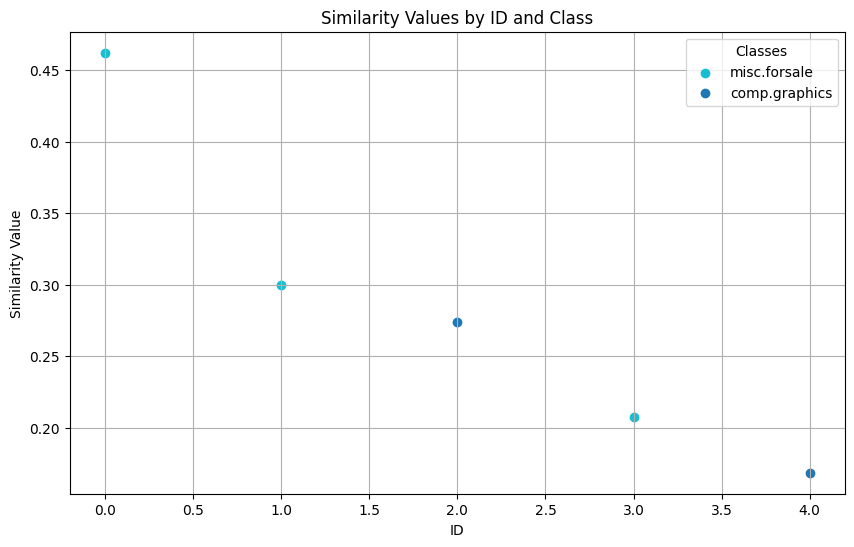

Document ID: 5510
Class: misc.forsale
Similarity Value: 0.46
Text Preview:
I am looking for a 286 motherboard, preferable 12 or 16, 640k or 1 meg
RAM. I am also looking for a VGA card. Am willing to trade 1200
external, 5.25" LD Drive, 8088 motherboard, monochrome monitor, Game
Boy, in some combination for the above. Libertarian, atheist, semi-
anarchal Techno-Rat.
--------------------------------------------------------------------------------
Document ID: 4922
Class: misc.forsale
Similarity Value: 0.30
Text Preview:
For sale: Nintendo Game Boy, Tetris, Castlevania Adventure, All-Star
Challenge, Nemesis, Play-Action football, link cable. Make me an
offer. Libertarian, atheist, semi-anarchal Techno-Rat.
--------------------------------------------------------------------------------
Document ID: 4347
Class: comp.graphics
Similarity Value: 0.27
Text Preview:
It's really not that hard to do. There are books out there which
explain everything, and the basic 3D functions, translation, rota

In [67]:
''' 
Documento 3 (5582):
 - Clase original: misc.forsale
 - Los documentos con mayor similaridad pertenecen a dos clases: misc.forsale y comp.graphics
 - Al analizar los textos de cada documento, se aprecia que todos hablan de hardware
 - Llama la atencion que en tres textos se observa la frase: "Libertarian, atheist, semi-
anarchal Techno-Rat", por lo que probablemente todas estos documentos hayan sido escritos por un mismo
usuario. (incluso el original)


'''

data = find_most_similar(indices[2])

plot_most_similar(data = data)

display_first_n_words(data = data, n = 100)


/tmp/ipykernel_9602/1039797579.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_classes))


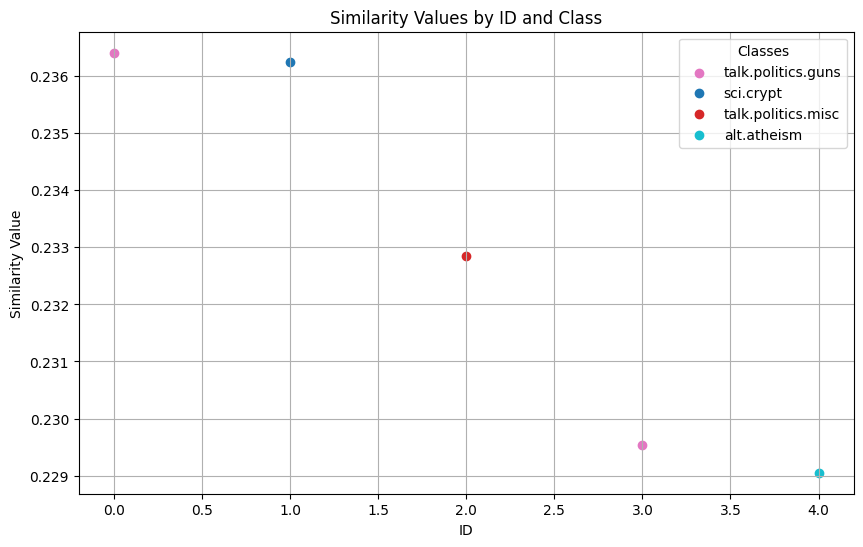

Document ID: 6894
Class: talk.politics.guns
Similarity Value: 0.24
Text Preview:
Here is a press release from the White House. President Clinton's
Remarks On Waco With Q/A To: National Desk Contact: White House Office
of the Press Secretary, 202-456-2100 WASHINGTON, April 20 -- Following
are remarks by President Clinton in a question and answer session with
the press: 1:36 P.M. EDT THE PRESIDENT: On February the 28th, four
federal agents were killed in the line of duty trying to enforce the
law against the Branch Davidian compound, which had illegally
stockpiled weaponry and ammunition, and placed innocent children at
risk. Because the BATF operation had failed to meet its objective, a
51-day
--------------------------------------------------------------------------------
Document ID: 5856
Class: sci.crypt
Similarity Value: 0.24
Text Preview:
Thanks for posting this and making it available. This post will be
LONG, I will comment on most of it, and am reluctantly leaving all of
the orig

In [71]:
''' 
Documento 4 (4793): 
- Clase original: talk.politics.guns
- Clases de los mas similares: talk.politics.guns, sci.crypt, talk.politics.misc y alt.atheism
- Se observa que presentan muchas clases distintas pero todos los textos estan relacionados a temas serios que suelen escribirse de forma similar,
por lo tanto, aun cuando las clases son distintas, que se los tome como textos similares tiene sentido. 
'''

data = find_most_similar(indices[3])

plot_most_similar(data = data)

display_first_n_words(data = data, n = 100)

/tmp/ipykernel_9602/1039797579.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_classes))


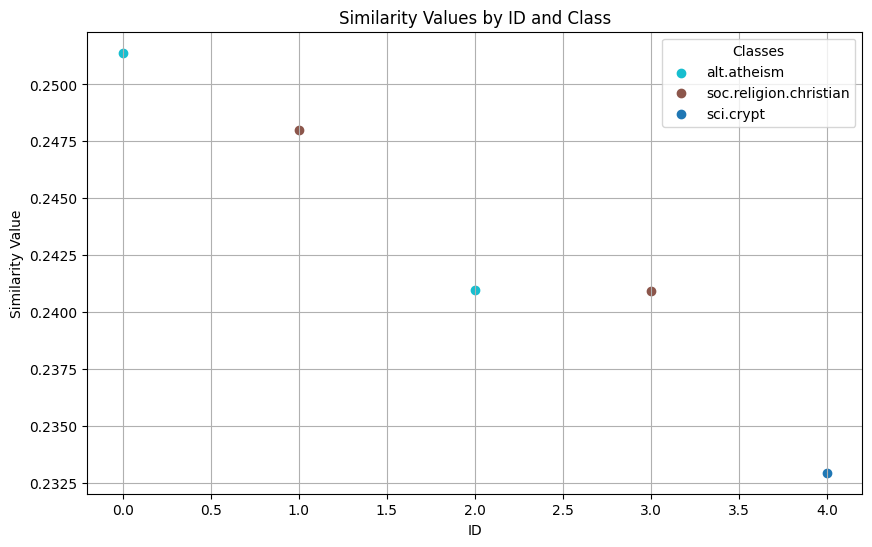

Document ID: 10836
Class: alt.atheism
Similarity Value: 0.25
Text Preview:
Archive-name: atheism/faq Alt-atheism-archive-name: faq Last-modified:
5 April 1993 Version: 1.1 Alt.Atheism Frequently-Asked Questions This
file contains responses to articles which occur repeatedly in
alt.atheism. Points covered here are ones which are not covered in the
"Introduction to Atheism"; you are advised to read that article as
well before posting. These answers are not intended to be exhaustive
or definitive. The purpose of the periodic FAQ postings is not to
stifle debate, but to raise its level. If you have something to say
concerning one of these questions and which isn't covered by the
answer given, please feel free to make your
--------------------------------------------------------------------------------
Document ID: 759
Class: soc.religion.christian
Similarity Value: 0.25
Text Preview:
Oh contrer mon captitan! There is a way. Certainly it is not by human
reason. Certainly it is not by human 

In [76]:
''' 
Documento 5 (3813): 
- Clase original: rec.sport.hockey
- Clases cercanas: alt.atheism, soc.religion.christian y sci.crypt
- En este caso las clases son muy diferentes con la clase original pero se observa que incluye la frase: "The official Language of Golf is Profanity".
La cual al incluir la palabra Profanity puede ser que este haciendo que los documentos mas cercanos sean de religion/ateismo y no de deporte. 
'''

data = find_most_similar(indices[4])

plot_most_similar(data = data)

display_first_n_words(data = data, n = 100)

#### Ejercicio 2

Entrenar modelos de clasificación Naïve Bayes para maximizar el desempeño de clasificación
(f1-score macro) en el conjunto de datos de test. Considerar cambiar parámteros
de instanciación del vectorizador y los modelos y probar modelos de Naïve Bayes Multinomial
y ComplementNB.

Max F1 score is: 0.6534497959493145 with max_df = 0.03


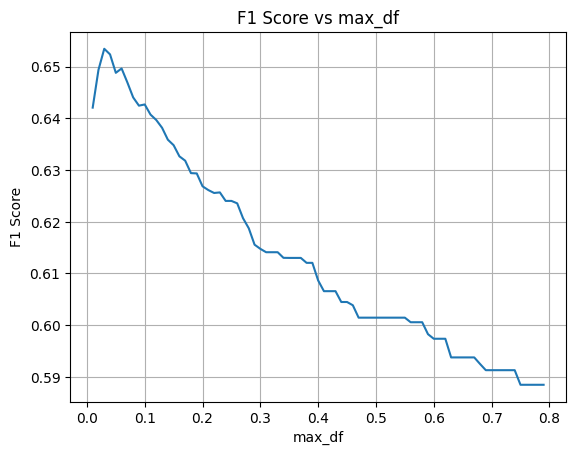

In [48]:
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

# De acuerdo a la documentacion: 
# max_df: When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold 
# Variamos este parametro y vemos como cambia F1:
f1_list = []
max_df_list = list(np.arange(0.01, 0.8, 0.01))
for max_df in max_df_list:
    # Probamos eliminando las palabras con muy alta frecuencia
    tfidfvect = TfidfVectorizer(max_df=max_df)
    # Con max_df=0.10 sube F1 a 0.642

    X_train = tfidfvect.fit_transform(newsgroups_train.data)

    y_train = newsgroups_train.target

    idx2word = {v: k for k,v in tfidfvect.vocabulary_.items()}

    clf = MultinomialNB()
    clf.fit(X_train, y_train)

    X_test = tfidfvect.transform(newsgroups_test.data)
    y_test = newsgroups_test.target
    y_pred =  clf.predict(X_test)

    f1_list.append(f1_score(y_test, y_pred, average='macro'))

print(f"Max F1 score is: {max(f1_list)} with max_df = {max_df_list[np.argmax(f1_list)]}")

plt.plot(max_df_list, f1_list)
plt.title("F1 Score vs max_df")
plt.xlabel('max_df')
plt.ylabel('F1 Score')
plt.grid(True)


Repetimos la prueba pero usando ComplementNB

Max F1 score is: 0.6953220091906351 with max_df = 0.060000000000000005


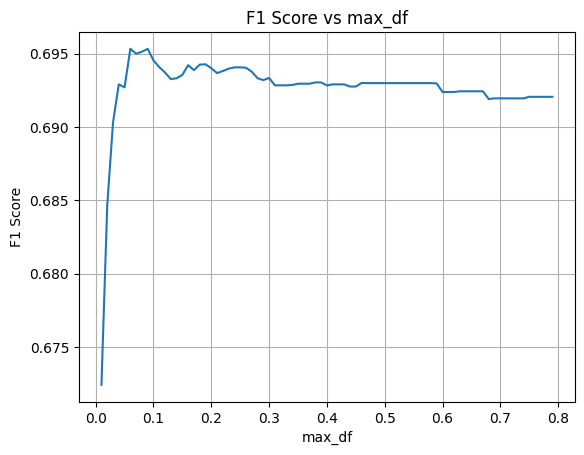

In [49]:
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

# De acuerdo a la documentacion: 
# max_df: When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold 
# Variamos este parametro y vemos como cambia F1:
f1_list = []
max_df_list = list(np.arange(0.01, 0.8, 0.01))
for max_df in max_df_list:
    # Probamos eliminando las palabras con muy alta frecuencia
    tfidfvect = TfidfVectorizer(max_df=max_df)
    # Con max_df=0.10 sube F1 a 0.642

    X_train = tfidfvect.fit_transform(newsgroups_train.data)

    y_train = newsgroups_train.target

    idx2word = {v: k for k,v in tfidfvect.vocabulary_.items()}

    clf = ComplementNB()
    clf.fit(X_train, y_train)

    X_test = tfidfvect.transform(newsgroups_test.data)
    y_test = newsgroups_test.target
    y_pred =  clf.predict(X_test)

    f1_list.append(f1_score(y_test, y_pred, average='macro'))

print(f"Max F1 score is: {max(f1_list)} with max_df = {max_df_list[np.argmax(f1_list)]}")

plt.plot(max_df_list, f1_list)
plt.title("F1 Score vs max_df")
plt.xlabel('max_df')
plt.ylabel('F1 Score')
plt.grid(True)

Se observa que: 
* El desempeño del modelo MultinomialNB mejora al eliminar aquellas palabras con alta frecuencia, aunque comienza a empeorar cuando max_df<0.3. El mejor resultado se encuentra con max_df = 0.3 con un F1 de 0.65

* En el caso de ComplementNB, tambien mejora el desempeño al eliminar las palabras de alta frecuencia pero esta mejora es menos pronunciada. El mejor resultado se encuentra con max_df = 0.06 obteniendo un F1 = 0.695

#### Ejercicio 3 

In [50]:
X_train.shape

(11314, 101630)

In [57]:
# Trasponemos la matriz X_train para obtener la matriz termino-documento
X_train_t = X_train.transpose()
X_train_t.shape

(101630, 11314)

In [61]:
# Creamos funcion para encontrar las palabras mas similares:
idx2word = {v: k for k,v in tfidfvect.vocabulary_.items()}

def find_most_similar_words(input_idx, n=5):

    cossim = cosine_similarity(X_train_t[input_idx], X_train_t)[0]

    most_similar_values = np.sort(cossim)[::-1][1:n+1]
    n_most_similar_words = np.argsort(cossim)[::-1][1:n+1]

    sim_data = {idx2word[sim_idx]: most_similar_values[it]
                 for it, sim_idx in enumerate(n_most_similar_words)}
    
    return sim_data

In [69]:
# Seleccionamos las palabras: laptop, job, president, game and dog

# laptob:
find_most_similar_words(tfidfvect.vocabulary_['laptop'])

{'undemanding': np.float64(0.20038894867246687),
 'portruding': np.float64(0.19551133924911976),
 'yea': np.float64(0.1661310407060149),
 'wysiwyg': np.float64(0.15790743262398882),
 'lisgollan': np.float64(0.15454181059588584)}

In [63]:
# Job:
find_most_similar_words(tfidfvect.vocabulary_['job'])

{'estatic': np.float64(0.2048912174687755),
 'wage': np.float64(0.18002646077297618),
 'computationally': np.float64(0.17096076037942706),
 'hangeth': np.float64(0.16429182571162104),
 'stretcheth': np.float64(0.16429182571162104)}

In [70]:
# computer:
find_most_similar_words(tfidfvect.vocabulary_['computer'])

{'decwriter': np.float64(0.1556542861037236),
 'harkens': np.float64(0.15121252044419814),
 'deluged': np.float64(0.15121252044419814),
 'shopper': np.float64(0.14391497699672892),
 'and': np.float64(0.13565520720989388)}

In [66]:
# game:
find_most_similar_words(tfidfvect.vocabulary_['game'])

{'games': np.float64(0.21171896884956737),
 'espn': np.float64(0.19511573175826355),
 'hockey': np.float64(0.18120851676449076),
 'team': np.float64(0.18027083119957632),
 'scored': np.float64(0.1747410651806761)}

Los valores de la matriz traspuesta no son buenos descriptores de las palabras, ya que solo en el caso de la palabra "game" las palabras más similares también tienen una similitud semántica.